Bibliotecas

In [87]:
import numpy as np
from random import randint
from numpy.core.numeric import Inf
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby

Ambiente

In [2]:
def create_env(n_rows, n_cols):
    env = np.full((n_rows, n_cols), '-')
    env = add_margin(env)
    env = add_vehicles(env)
    env = add_player(env)
    return env

In [3]:
def add_vehicles(env):
    n_rows = env.shape[0]
    n_cols = env.shape[1]
    for row in range(1, n_rows-1):
        column_with_vehicle = randint(0, n_cols-1)
        env[row, column_with_vehicle] = 'O'
    return env    

In [4]:
def add_player(env):
    mid_col = env.shape[1] // 2
    env[0,mid_col] = 'A'
    return env

In [5]:
def add_margin(env):
    env[0] = 'I'
    env[-1] = 'F'
    return env

In [6]:
def move_player(env, pos_A, new_pos_A):
    mid_col = env.shape[1] // 2
    if env[pos_A, mid_col] != 'O': env[pos_A, mid_col] = '-'
    while env[new_pos_A, mid_col] == 'O':
        valid_pos = max(0, new_pos_A-2)
        new_pos_A = valid_pos
    env[new_pos_A, mid_col] = 'A'
    return env

In [7]:
def get_player(env):
    mid_col = (len(env[:][0])) // 2
    for i in range(len(env)):
        if env[i, mid_col] == 'A':
            return i
    return False

In [8]:
def move_vehicles(env):
    n_rows, n_cols = env.shape
    for row in range(1, n_rows-1):
        pos_vechicle = np.where(env[row,] == 'O')[0]
        if pos_vechicle > 0: 
            if env[row, pos_vechicle-1] == 'A': 
                env = move_player(env, row, row-2)
            env[row, pos_vechicle-1] = 'O'
        else:
            if env[row, pos_vechicle-1] == 'A': 
                env = move_player(env, row, row-2)
            env[row, -1] = 'O'
        env[row, pos_vechicle] = '-'
    return env

In [9]:
def is_valid_state(state, action, s_linha, n_states):
    if state+action < 0 or state+action >= n_states: 
        return False
    if state+action == s_linha: return True
    return False

In [10]:
def transition_matrix(states, actions):
    n_states = len(states)
    n_actions = len(actions)
    transition = np.zeros((n_states, n_actions, n_states))  
    
    for state in states:
        for action in range(n_actions):
            s_linha = state + actions[action]
            if (s_linha < 0 or 
            s_linha >= n_states or 
            state == (n_states)-1):
                s_linha = state
            transition[state, action, s_linha] = 1
    return transition

In [11]:
def is_terminal_state(env, pos):
    if pos == env.shape[0]-1:
        return True
    return False

Value Iteration

In [12]:
def value_iteration(states, actions, rewards, transition, V):
    n_equacoes = 0
    while True:
        old_v = V
        for s in reversed(range(len(states))):
            v = V[s]
            max_v = 0
            for a in actions:
                v_this_action = 0
                for s_linha in reversed(range(len(states))):
                    v_this_action += rewards[states[s_linha]] + 0.9*transition[s,a,s_linha]*old_v[s_linha]
                    n_equacoes +=1
                    if v_this_action > max_v:
                        max_v = v_this_action
            V[s] = max_v
        if all(old_v[s] == V[s] for s in range(len(states))): break
    return V, n_equacoes

Hiperparâmetros

In [20]:
temp_env = create_env(10,9)
mid_col = temp_env.shape[1] // 2
n_games = 360

equacoes = list()
scores = list()
mid_col = temp_env.shape[1] // 2
time_limit = 272
actions = np.array([1, 0, -1])
rewards = {'O':-1, '-':0, 'A':0, 'I':0, 'F':1}
transition = transition_matrix(np.arange(len(temp_env)), actions)
mean_score = 0

Execução de 1000 jogos com Value Iteration

In [99]:
for game in range(n_games):
    env = create_env(10,9)
    pos_a = get_player(env)
    score = 0
    for i in range(time_limit):
        V = [0 for _ in range(len(env))]
        states = env[:,mid_col+1]
        v_i, n_equacoes = value_iteration(states, actions, rewards, transition, V)
        equacoes.append(n_equacoes)
        arg_max_act = 0
        possible_actions = []
        best_act = 0

        for pos_a_linha in range(len(states)):
            for action in actions:
                if transition[pos_a, action, pos_a_linha] != 0:
                    possible_actions.append(transition[pos_a, action, pos_a_linha])
        for possible_action in possible_actions:
            if v_i[int(pos_a + possible_action)] > arg_max_act:
                arg_max_act = v_i[int(pos_a + possible_action)]
                best_act = possible_action

        env = move_player(env, pos_a, int(pos_a + best_act))
        env = move_vehicles(env)
        pos_a = get_player(env)
        if is_terminal_state(env, pos_a):
            score += 1
            env[0,mid_col] = 'A'
            env[env.shape[0]-1,mid_col] = 'F'
            pos_a = get_player(env)
    mean_score += score
    scores.append(score)
    if game % 100 == 0: print("Iteração", game)

mean_score /= n_games
print("MEAN SCORE:", mean_score)

Iteração 0
Iteração 100
Iteração 200
Iteração 300
MEAN SCORE: 25.860725308641975


/home/vinicius/.local/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


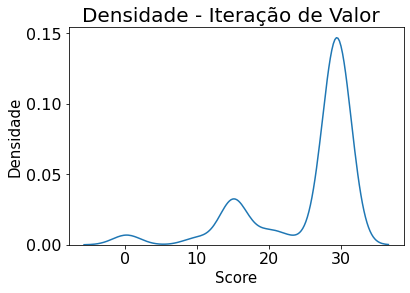

In [100]:
sns.kdeplot(scores,bw=0.25)
plt.figtext(.5,.9,'Densidade - Iteração de Valor', fontsize=20, ha='center')
plt.xlabel("Score", fontsize = 15)
plt.ylabel("Densidade", fontsize = 15)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt. show()

120
120
120


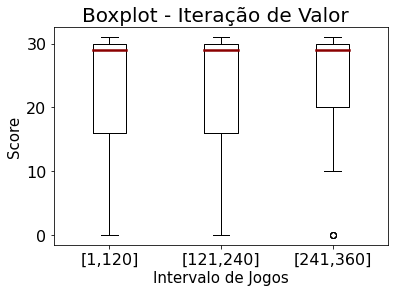

In [131]:
np.arange(n_games)
epoca = np.arange(n_games)

dados = [scores[0:120], scores[120:240], scores[240:360]]
f, ax = plt.subplots()
for dado in dados:
    print(len(dado))


ax.boxplot(dados, medianprops = dict(linewidth=2.5, color='darkred'))
plt.figtext(.5,.9,'Boxplot - Iteração de Valor', fontsize=20, ha='center')
plt.xlabel('Intervalo de Jogos', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xticklabels(['[1,120]','[121,240]','[241,360]'])

plt.show()

In [28]:

np.mean(equacoes)

300.0

Policy Iteration

In [132]:
def policy_evaluation(policy, states):
    V = [0 for _ in range(len(states))]
    while True:
        old_v = V
        for s in reversed(range(len(states))):
            a = policy[s]
            if s+a >= 0 and s+a < len(states):
                V[s] = rewards[states[int(s+a)]]
            else: V[s] = 0
            for s_linha in reversed(range(len(states))):
                V[s] += transition[s,a,s_linha]*old_v[s_linha]
        if all(old_v[s] == V[s] for s in range(len(states))): 
            break
    return V

In [133]:
def policy_improvement(V, states, actions):
    pi = [actions[0] for states in range(len(states))]
    for s in reversed(range(len(states))):
        Q = {}
        for a in actions:
            if s+a >= 0 and s+a < len(states):
                Q[a] = rewards[states[int(s+a)]]
            else:
                Q[a] = 0
            for s_linha in reversed(range(len(states))):
                Q[a] += transition[s,a,s_linha]*V[s_linha]
        pi[s] = max(Q, key=Q.get)

    return pi

In [134]:
def policy_iteration(states, actions, rewards, transition):
    i = 0
    pi = [actions[1] for _ in range(len(states))]
    pi_stable = False
    for i in range(100):
        old_pi = pi
        V = policy_evaluation(pi, states)
        pi = policy_improvement(V, states, actions)
        if all(old_pi[s] == pi[s] for s in range(len(states))):
            pi_stable = True 
            break
    return pi

In [135]:
temp_env = create_env(10,9)
score = 0
mid_col = temp_env.shape[1] // 2
n_games = 360
mean_score = 0
scores = list()

mid_col = temp_env.shape[1] // 2
time_limit = 272
actions = np.array([1, 0, -1])
rewards = {'O':-1, '-':0, 'A':0, 'I':0, 'F':1}
transition = transition_matrix(np.arange(len(temp_env)), actions)

In [136]:
for game in range(n_games):
    env = create_env(10,9)
    pos_a = get_player(env)
    score = 0

    for i in range(time_limit):
        states = env[:,mid_col+1]
        pi = policy_iteration(states, actions, rewards, transition)
        env = move_player(env, pos_a, pi[pos_a])
        env = move_vehicles(env)
        pos_a = get_player(env)

        if is_terminal_state(env, pos_a):
            score += 1
            env[0,mid_col] = 'A'
            env[env.shape[0]-1,mid_col] = 'F'
            pos_a = get_player(env)
    mean_score += score
    scores.append(score)
    print("Game", game, "- Score:", score)
mean_score /= n_games
print("MEAN SCORE:", mean_score)

Game 0 - Score: 30
Game 1 - Score: 30
Game 2 - Score: 31
Game 3 - Score: 30
Game 4 - Score: 30
Game 5 - Score: 0
Game 6 - Score: 30
Game 7 - Score: 30
Game 8 - Score: 0
Game 9 - Score: 30
Game 10 - Score: 30
Game 11 - Score: 0
Game 12 - Score: 0
Game 13 - Score: 30
Game 14 - Score: 30
Game 15 - Score: 0
Game 16 - Score: 30
Game 17 - Score: 30
Game 18 - Score: 30
Game 19 - Score: 30
Game 20 - Score: 30
Game 21 - Score: 30
Game 22 - Score: 30
Game 23 - Score: 30
Game 24 - Score: 0
Game 25 - Score: 31
Game 26 - Score: 30
Game 27 - Score: 0
Game 28 - Score: 31
Game 29 - Score: 30
Game 30 - Score: 30
Game 31 - Score: 30
Game 32 - Score: 30
Game 33 - Score: 30
Game 34 - Score: 30
Game 35 - Score: 31
Game 36 - Score: 0
Game 37 - Score: 30
Game 38 - Score: 30
Game 39 - Score: 30
Game 40 - Score: 30
Game 41 - Score: 30
Game 42 - Score: 0
Game 43 - Score: 30
Game 44 - Score: 30
Game 45 - Score: 30
Game 46 - Score: 30
Game 47 - Score: 30
Game 48 - Score: 0
Game 49 - Score: 30
Game 50 - Score: 30


/home/vinicius/.local/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


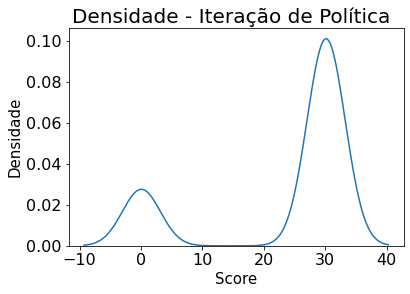

In [138]:
sns.kdeplot(scores,bw=0.25)
plt.figtext(.5,.9,'Densidade - Iteração de Política', fontsize=20, ha='center')
plt.xlabel("Score", fontsize = 15)
plt.ylabel("Densidade", fontsize = 15)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt. show()

120
120
120


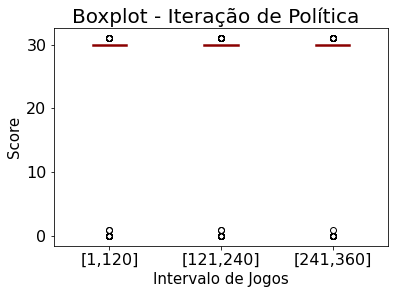

In [139]:
np.arange(n_games)
epoca = np.arange(n_games)

dados = [scores[0:120], scores[120:240], scores[240:360]]
f, ax = plt.subplots()
for dado in dados:
    print(len(dado))


ax.boxplot(dados, medianprops = dict(linewidth=2.5, color='darkred'))
plt.figtext(.5,.9,'Boxplot - Iteração de Política', fontsize=20, ha='center')
plt.xlabel('Intervalo de Jogos', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xticklabels(['[1,120]','[121,240]','[241,360]'])

plt.show()